# Household Load using LSTM

### Data Sources
* Location: Austin, TX
* Dates: 2016-01-01 to 2017-06-30
* Weather: Weather Underground. 
 * Link: https://www.wunderground.com/
 * Data resolution: ~ 1 hour
 * Access: open
* Energy: Pecan Street. 
 * Link: http://www.pecanstreet.org/
 * Data resolution: 1 minute
 * Access: universities

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt                        
%matplotlib inline

def load_data(filename):
	data = pd.read_csv(filename, index_col="datetime")
	return data

# forecast resolution
resol = 60
# household id selected
household = 93

                           hum     tempC
datetime                                
2014-12-30 00:00:00  85.000000  6.700000
2014-12-30 01:00:00  85.040000  6.694000
2014-12-30 02:00:00  87.575315  6.312892
2014-12-30 03:00:00  92.543018  5.703941
2014-12-30 04:00:00  97.666667  6.058333


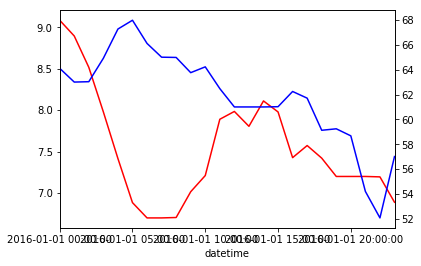

In [2]:
# load weather data
weather = load_data("preparedData/weather" + str(resol) + ".csv")
print(weather.head())

weather.loc['2016-01-01 00:00:00':'2016-01-01 23:00:00']['tempC'].plot(style='r')
weather.loc['2016-01-01 00:00:00':'2016-01-01 23:00:00']['hum'].plot(secondary_y=True, style='b')

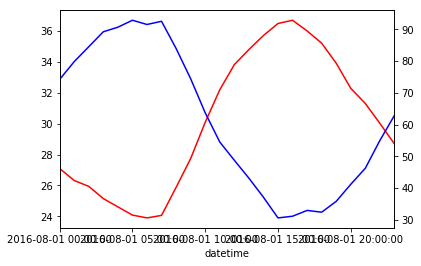

In [3]:
weather.loc['2016-08-01 00:00:00':'2016-08-01 23:00:00']['tempC'].plot(style='r')
weather.loc['2016-08-01 00:00:00':'2016-08-01 23:00:00']['hum'].plot(secondary_y=True, style='b')

                          use  gen
datetime                          
2015-12-23 00:00:00  1.174933  0.0
2015-12-23 01:00:00  0.899850  0.0
2015-12-23 02:00:00  0.432117  0.0
2015-12-23 03:00:00  0.402633  0.0
2015-12-23 04:00:00  0.573333  0.0


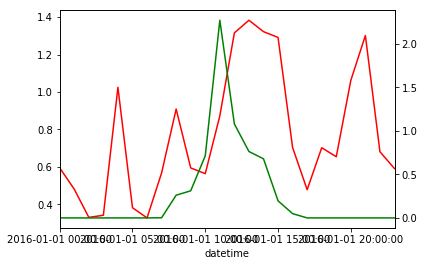

In [4]:
# load energy data
energy = load_data("preparedData/energy" + str(resol) + "_" + str(household) +".csv")
print(energy.head())

energy.loc['2016-01-01 00:00:00':'2016-01-01 23:00:00']['use'].plot(style='r')
energy.loc['2016-01-01 00:00:00':'2016-01-01 23:00:00']['gen'].plot(secondary_y=True, style='g')

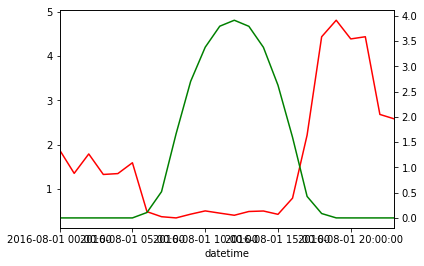

In [5]:
energy.loc['2016-08-01 00:00:00':'2016-08-01 23:00:00']['use'].plot(style='r')
energy.loc['2016-08-01 00:00:00':'2016-08-01 23:00:00']['gen'].plot(secondary_y=True, style='g')

# Power Demand Forecasting

### Prepare Dataset to Feed LSTM

In [6]:
from datetime import date, datetime, timedelta
from sklearn.preprocessing import MinMaxScaler

days = [1, 2, 7]
def prepare_dataset_pv(weather, energy, resol, days):
	val_days = [1, 2, 3, 4, 5, 6, 7]
    
	# chunk data in days
	weather = weather.loc['2016-01-01':'2017-07-01']
	
	startDate = date(2016, 1, 1)
	endDate = date(2017, 6, 30)
	
	n_features = 5

	x_train = np.empty((1, 1440//resol, n_features))
	y_train = np.empty((1, 1440//resol))
	
	x_val = np.empty((1, 1440//resol, n_features))
	y_val = np.empty((1, 1440//resol))
	
	if resol == 60:
		minSt = '00'
	elif resol == 30:
		minSt = '30'
	elif resol == 15:
		minSt = '45'
		
	countTrain = 1
	countTest = 1
	countVal = 1
	
	while startDate <= endDate:
		weekday = startDate.weekday()
		
		startDateSt = startDate.strftime('%Y-%m-%d')
		startDatetimeSt = startDateSt + ' 00:00:00'
		endDatetimeSt = startDateSt + ' 23:' + minSt + ':00'
		x = weather.loc[startDatetimeSt:endDatetimeSt]
		x = x.reset_index(drop=True)
		
		if weekday < 5:
			x['weekday'] = pd.DataFrame(data=np.zeros((1440//resol, 1)))
		else:
			x['weekday'] = pd.DataFrame(np.ones((1440 // resol, 1)))
		
		
		days = [1, 2, 7]
		
		for day in days:
			# last week consumption
			date_past = startDate - timedelta(days=day)
			date_past = date_past.strftime('%Y-%m-%d')
			startDatetimeSt = date_past + ' 00:00:00'
			endDatetimeSt = date_past + ' 23:' + minSt + ':00'
			x_i = energy.loc[startDatetimeSt:endDatetimeSt]
			'''
			x_i = pd.DataFrame([x_i])
			'''
			x_i = x_i.reset_index(drop=True)
			column_name = 'day_' + str(day)
			x_i = pd.DataFrame(x_i['gen'])
			x[column_name] = x_i
		
		x = x.as_matrix()
		# print(x.shape)
		x = x.reshape(1, x.shape[0], x.shape[1])
		# print(x.shape)
		
		
		
		# output on this day
		y = energy.loc[startDatetimeSt:endDatetimeSt]
		y = y.reset_index(drop=True)
		y = pd.DataFrame(y['gen']).as_matrix()
		# print(y.shape)
		y = y.reshape(1, y.shape[0])
		# print(y.shape)
		
		if startDate < date(2017, 1, 1):
			day = startDate.day
			if int(day) in val_days:
				# validation set
				if countVal == 1:
					x_val = x
					y_val = y
					countVal += 1
				else:
					x_val = np.concatenate((x_val, x), axis=0)
					y_val = np.concatenate((y_val, y), axis=0)
			else:
				# training set
				if countTrain == 1:
					x_train = x
					y_train = y
					countTrain += 1
				else:
					x_train = np.concatenate((x_train, x), axis=0)
					y_train = np.concatenate((y_train, y), axis=0)
		elif startDate < date(2017, 7, 1):
			if countTest == 1:
				x_test = x
				y_test = y
				countTest += 1
			else:
				x_test = np.concatenate((x_test, x), axis=0)
				y_test = np.concatenate((y_test, y), axis=0)
		
		# update date
		startDate = startDate + timedelta(days=1)
	
	print(x_train.shape)
	print(y_train.shape)
	print(x_val.shape)
	print(y_val.shape)
	print(x_test.shape)
	print(y_test.shape)
	
	# ensure all data is float
	x_train = x_train.astype('float32')
	y_train = y_train.astype('float32')
	x_val = x_val.astype('float32')
	y_val = y_val.astype('float32')
	x_test = x_test.astype('float32')
	y_test = y_test.astype('float32')
	
	n_features = x_train.shape[2]
	
	# Normalize X
	x_train = x_train.reshape((-1, n_features))
	x_val = x_val.reshape((-1, n_features))
	x_test = x_test.reshape((-1, n_features))
	
	scalerFeatures = MinMaxScaler(feature_range=(0, 1))
	x_train = scalerFeatures.fit_transform(x_train)
	x_val = scalerFeatures.transform(x_val)
	x_test = scalerFeatures.transform(x_test)
	
	x_train = x_train.reshape((-1, 1440 // resol, n_features))
	x_val = x_val.reshape((-1, 1440 // resol, n_features))
	x_test = x_test.reshape((-1, 1440 // resol, n_features))
	
	# Normalize y
	y_train = y_train.reshape((-1))
	y_val = y_val.reshape((-1))
	y_test = y_test.reshape((-1))
	
	scalerOutput = MinMaxScaler(feature_range=(0, 1))
	y_train = scalerOutput.fit_transform(y_train)
	y_val = scalerOutput.transform(y_val)
	y_test = scalerOutput.transform(y_test)
	
	y_train = y_train.reshape((-1, 1440 // resol))
	y_val = y_val.reshape((-1, 1440 // resol))
	y_test = y_test.reshape((-1, 1440 // resol))
	
	print(x_train.shape)
	print(y_train.shape)
	print(x_val.shape)
	print(y_val.shape)
	print(x_test.shape)
	print(y_test.shape)
	
	return x_train, y_train, x_val, y_val, x_test, y_test, scalerFeatures, scalerOutput


In [7]:
x_train, y_train, x_val, y_val, x_test, y_test, scalerFeatures, scalerOutput\
		= prepare_dataset_pv(weather, energy, resol, days)

(282, 24, 6)
(282, 24)
(84, 24, 6)
(84, 24)
(181, 24, 6)
(181, 24)
(282, 24, 6)
(282, 24)
(84, 24, 6)
(84, 24)
(181, 24, 6)
(181, 24)


/home/alberto/.local/lib/python3.5/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/alberto/.local/lib/python3.5/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/alberto/.local/lib/python3.5/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your dat

### Define RNN Model

In [8]:
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras.layers import LSTM, Dense

timesteps = 1440//resol
input_shape = (x_train.shape[1], x_train.shape[2])

# design network
modelLoad = Sequential()
modelLoad.add(LSTM(timesteps, return_sequences=True, input_shape=input_shape))
modelLoad.add(LSTM(timesteps))
modelLoad.add(Dense(timesteps, activation='sigmoid'))
print(modelLoad.summary())

# compilation
# model.compile(loss='mae', optimizer='adam')
modelLoad.compile(loss='mean_squared_error', optimizer='adam')

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 24, 24)            2976      
_________________________________________________________________
lstm_2 (LSTM)                (None, 24)                4704      
_________________________________________________________________
dense_1 (Dense)              (None, 24)                600       
Total params: 8,280
Trainable params: 8,280
Non-trainable params: 0
_________________________________________________________________
None


### Training Model 

Train on 282 samples, validate on 84 samples
Epoch 1/1000
Epoch 00000: val_loss improved from inf to 0.16313, saving model to saved_models/weights.best.load_60.hdf5
0s - loss: 0.1721 - val_loss: 0.1631
Epoch 2/1000
Epoch 00001: val_loss improved from 0.16313 to 0.13714, saving model to saved_models/weights.best.load_60.hdf5
0s - loss: 0.1525 - val_loss: 0.1371
Epoch 3/1000
Epoch 00002: val_loss improved from 0.13714 to 0.09999, saving model to saved_models/weights.best.load_60.hdf5
0s - loss: 0.1210 - val_loss: 0.1000
Epoch 4/1000
Epoch 00003: val_loss improved from 0.09999 to 0.06725, saving model to saved_models/weights.best.load_60.hdf5
0s - loss: 0.0848 - val_loss: 0.0672
Epoch 5/1000
Epoch 00004: val_loss improved from 0.06725 to 0.04530, saving model to saved_models/weights.best.load_60.hdf5
0s - loss: 0.0568 - val_loss: 0.0453
Epoch 6/1000
Epoch 00005: val_loss improved from 0.04530 to 0.03243, saving model to saved_models/weights.best.load_60.hdf5
0s - loss: 0.0387 - val_loss: 

Epoch 00051: val_loss improved from 0.01782 to 0.01782, saving model to saved_models/weights.best.load_60.hdf5
0s - loss: 0.0182 - val_loss: 0.0178
Epoch 53/1000
Epoch 00052: val_loss improved from 0.01782 to 0.01781, saving model to saved_models/weights.best.load_60.hdf5
0s - loss: 0.0182 - val_loss: 0.0178
Epoch 54/1000
Epoch 00053: val_loss improved from 0.01781 to 0.01780, saving model to saved_models/weights.best.load_60.hdf5
0s - loss: 0.0182 - val_loss: 0.0178
Epoch 55/1000
Epoch 00054: val_loss improved from 0.01780 to 0.01780, saving model to saved_models/weights.best.load_60.hdf5
0s - loss: 0.0182 - val_loss: 0.0178
Epoch 56/1000
Epoch 00055: val_loss improved from 0.01780 to 0.01779, saving model to saved_models/weights.best.load_60.hdf5
0s - loss: 0.0182 - val_loss: 0.0178
Epoch 57/1000
Epoch 00056: val_loss improved from 0.01779 to 0.01778, saving model to saved_models/weights.best.load_60.hdf5
0s - loss: 0.0182 - val_loss: 0.0178
Epoch 58/1000
Epoch 00057: val_loss improv

Epoch 00102: val_loss improved from 0.01764 to 0.01764, saving model to saved_models/weights.best.load_60.hdf5
0s - loss: 0.0180 - val_loss: 0.0176
Epoch 104/1000
Epoch 00103: val_loss improved from 0.01764 to 0.01764, saving model to saved_models/weights.best.load_60.hdf5
0s - loss: 0.0180 - val_loss: 0.0176
Epoch 105/1000
Epoch 00104: val_loss improved from 0.01764 to 0.01764, saving model to saved_models/weights.best.load_60.hdf5
0s - loss: 0.0180 - val_loss: 0.0176
Epoch 106/1000
Epoch 00105: val_loss improved from 0.01764 to 0.01764, saving model to saved_models/weights.best.load_60.hdf5
0s - loss: 0.0180 - val_loss: 0.0176
Epoch 107/1000
Epoch 00106: val_loss improved from 0.01764 to 0.01764, saving model to saved_models/weights.best.load_60.hdf5
0s - loss: 0.0180 - val_loss: 0.0176
Epoch 108/1000
Epoch 00107: val_loss improved from 0.01764 to 0.01764, saving model to saved_models/weights.best.load_60.hdf5
0s - loss: 0.0180 - val_loss: 0.0176
Epoch 109/1000
Epoch 00108: val_loss 

Epoch 00154: val_loss improved from 0.00777 to 0.00752, saving model to saved_models/weights.best.load_60.hdf5
0s - loss: 0.0069 - val_loss: 0.0075
Epoch 156/1000
Epoch 00155: val_loss improved from 0.00752 to 0.00741, saving model to saved_models/weights.best.load_60.hdf5
0s - loss: 0.0067 - val_loss: 0.0074
Epoch 157/1000
Epoch 00156: val_loss improved from 0.00741 to 0.00734, saving model to saved_models/weights.best.load_60.hdf5
0s - loss: 0.0065 - val_loss: 0.0073
Epoch 158/1000
Epoch 00157: val_loss improved from 0.00734 to 0.00725, saving model to saved_models/weights.best.load_60.hdf5
0s - loss: 0.0064 - val_loss: 0.0073
Epoch 159/1000
Epoch 00158: val_loss improved from 0.00725 to 0.00702, saving model to saved_models/weights.best.load_60.hdf5
0s - loss: 0.0063 - val_loss: 0.0070
Epoch 160/1000
Epoch 00159: val_loss improved from 0.00702 to 0.00671, saving model to saved_models/weights.best.load_60.hdf5
0s - loss: 0.0061 - val_loss: 0.0067
Epoch 161/1000
Epoch 00160: val_loss 

Epoch 00216: val_loss did not improve
0s - loss: 0.0038 - val_loss: 0.0042
Epoch 218/1000
Epoch 00217: val_loss did not improve
0s - loss: 0.0038 - val_loss: 0.0042
Epoch 219/1000
Epoch 00218: val_loss improved from 0.00419 to 0.00417, saving model to saved_models/weights.best.load_60.hdf5
0s - loss: 0.0039 - val_loss: 0.0042
Epoch 220/1000
Epoch 00219: val_loss improved from 0.00417 to 0.00416, saving model to saved_models/weights.best.load_60.hdf5
0s - loss: 0.0039 - val_loss: 0.0042
Epoch 221/1000
Epoch 00220: val_loss did not improve
0s - loss: 0.0039 - val_loss: 0.0042
Epoch 222/1000
Epoch 00221: val_loss improved from 0.00416 to 0.00416, saving model to saved_models/weights.best.load_60.hdf5
0s - loss: 0.0039 - val_loss: 0.0042
Epoch 223/1000
Epoch 00222: val_loss improved from 0.00416 to 0.00411, saving model to saved_models/weights.best.load_60.hdf5
0s - loss: 0.0038 - val_loss: 0.0041
Epoch 224/1000
Epoch 00223: val_loss improved from 0.00411 to 0.00410, saving model to saved_

Epoch 00283: val_loss did not improve
0s - loss: 0.0034 - val_loss: 0.0039
Epoch 285/1000
Epoch 00284: val_loss did not improve
0s - loss: 0.0034 - val_loss: 0.0038
Epoch 286/1000
Epoch 00285: val_loss did not improve
0s - loss: 0.0034 - val_loss: 0.0039
Epoch 287/1000
Epoch 00286: val_loss did not improve
0s - loss: 0.0035 - val_loss: 0.0038
Epoch 288/1000
Epoch 00287: val_loss did not improve
0s - loss: 0.0036 - val_loss: 0.0038
Epoch 289/1000
Epoch 00288: val_loss did not improve
0s - loss: 0.0035 - val_loss: 0.0039
Epoch 290/1000
Epoch 00289: val_loss did not improve
0s - loss: 0.0034 - val_loss: 0.0039
Epoch 291/1000
Epoch 00290: val_loss did not improve
0s - loss: 0.0034 - val_loss: 0.0038
Epoch 292/1000
Epoch 00291: val_loss improved from 0.00381 to 0.00379, saving model to saved_models/weights.best.load_60.hdf5
0s - loss: 0.0035 - val_loss: 0.0038
Epoch 293/1000
Epoch 00292: val_loss did not improve
0s - loss: 0.0034 - val_loss: 0.0038
Epoch 294/1000
Epoch 00293: val_loss did n

Epoch 00358: val_loss did not improve
0s - loss: 0.0027 - val_loss: 0.0030
Epoch 360/1000
Epoch 00359: val_loss did not improve
0s - loss: 0.0027 - val_loss: 0.0031
Epoch 361/1000
Epoch 00360: val_loss did not improve
0s - loss: 0.0028 - val_loss: 0.0029
Epoch 362/1000
Epoch 00361: val_loss did not improve
0s - loss: 0.0028 - val_loss: 0.0030
Epoch 363/1000
Epoch 00362: val_loss did not improve
0s - loss: 0.0027 - val_loss: 0.0030
Epoch 364/1000
Epoch 00363: val_loss improved from 0.00292 to 0.00285, saving model to saved_models/weights.best.load_60.hdf5
0s - loss: 0.0026 - val_loss: 0.0029
Epoch 365/1000
Epoch 00364: val_loss did not improve
0s - loss: 0.0026 - val_loss: 0.0029
Epoch 366/1000
Epoch 00365: val_loss did not improve
0s - loss: 0.0026 - val_loss: 0.0030
Epoch 367/1000
Epoch 00366: val_loss did not improve
0s - loss: 0.0026 - val_loss: 0.0030
Epoch 368/1000
Epoch 00367: val_loss did not improve
0s - loss: 0.0027 - val_loss: 0.0029
Epoch 369/1000
Epoch 00368: val_loss did n

Epoch 00437: val_loss improved from 0.00252 to 0.00251, saving model to saved_models/weights.best.load_60.hdf5
0s - loss: 0.0023 - val_loss: 0.0025
Epoch 439/1000
Epoch 00438: val_loss did not improve
0s - loss: 0.0022 - val_loss: 0.0026
Epoch 440/1000
Epoch 00439: val_loss did not improve
0s - loss: 0.0022 - val_loss: 0.0026
Epoch 441/1000
Epoch 00440: val_loss did not improve
0s - loss: 0.0022 - val_loss: 0.0026
Epoch 442/1000
Epoch 00441: val_loss did not improve
0s - loss: 0.0023 - val_loss: 0.0027
Epoch 443/1000
Epoch 00442: val_loss did not improve
0s - loss: 0.0024 - val_loss: 0.0026
Epoch 444/1000
Epoch 00443: val_loss did not improve
0s - loss: 0.0026 - val_loss: 0.0025
Epoch 445/1000
Epoch 00444: val_loss did not improve
0s - loss: 0.0026 - val_loss: 0.0027
Epoch 446/1000
Epoch 00445: val_loss did not improve
0s - loss: 0.0023 - val_loss: 0.0027
Epoch 447/1000
Epoch 00446: val_loss did not improve
0s - loss: 0.0022 - val_loss: 0.0026
Epoch 448/1000
Epoch 00447: val_loss did n

Epoch 00521: val_loss improved from 0.00237 to 0.00235, saving model to saved_models/weights.best.load_60.hdf5
0s - loss: 0.0021 - val_loss: 0.0024
Epoch 523/1000
Epoch 00522: val_loss did not improve
0s - loss: 0.0021 - val_loss: 0.0024
Epoch 524/1000
Epoch 00523: val_loss did not improve
0s - loss: 0.0020 - val_loss: 0.0024
Epoch 525/1000
Epoch 00524: val_loss did not improve
0s - loss: 0.0020 - val_loss: 0.0024
Epoch 526/1000
Epoch 00525: val_loss did not improve
0s - loss: 0.0021 - val_loss: 0.0024
Epoch 527/1000
Epoch 00526: val_loss did not improve
0s - loss: 0.0021 - val_loss: 0.0024
Epoch 528/1000
Epoch 00527: val_loss did not improve
0s - loss: 0.0021 - val_loss: 0.0025
Epoch 529/1000
Epoch 00528: val_loss did not improve
0s - loss: 0.0021 - val_loss: 0.0026
Epoch 530/1000
Epoch 00529: val_loss did not improve
0s - loss: 0.0021 - val_loss: 0.0025
Epoch 531/1000
Epoch 00530: val_loss did not improve
0s - loss: 0.0022 - val_loss: 0.0024
Epoch 532/1000
Epoch 00531: val_loss impro

Epoch 00604: val_loss did not improve
0s - loss: 0.0019 - val_loss: 0.0024
Epoch 606/1000
Epoch 00605: val_loss did not improve
0s - loss: 0.0019 - val_loss: 0.0023
Epoch 607/1000
Epoch 00606: val_loss improved from 0.00218 to 0.00209, saving model to saved_models/weights.best.load_60.hdf5
0s - loss: 0.0018 - val_loss: 0.0021
Epoch 608/1000
Epoch 00607: val_loss did not improve
0s - loss: 0.0018 - val_loss: 0.0022
Epoch 609/1000
Epoch 00608: val_loss improved from 0.00209 to 0.00205, saving model to saved_models/weights.best.load_60.hdf5
0s - loss: 0.0018 - val_loss: 0.0020
Epoch 610/1000
Epoch 00609: val_loss did not improve
0s - loss: 0.0017 - val_loss: 0.0021
Epoch 611/1000
Epoch 00610: val_loss did not improve
0s - loss: 0.0018 - val_loss: 0.0023
Epoch 612/1000
Epoch 00611: val_loss did not improve
0s - loss: 0.0018 - val_loss: 0.0021
Epoch 613/1000
Epoch 00612: val_loss improved from 0.00205 to 0.00204, saving model to saved_models/weights.best.load_60.hdf5
0s - loss: 0.0017 - val

Epoch 00684: val_loss did not improve
0s - loss: 0.0015 - val_loss: 0.0020
Epoch 686/1000
Epoch 00685: val_loss did not improve
0s - loss: 0.0015 - val_loss: 0.0019
Epoch 687/1000
Epoch 00686: val_loss did not improve
0s - loss: 0.0016 - val_loss: 0.0020
Epoch 688/1000
Epoch 00687: val_loss did not improve
0s - loss: 0.0015 - val_loss: 0.0021
Epoch 689/1000
Epoch 00688: val_loss did not improve
0s - loss: 0.0015 - val_loss: 0.0018
Epoch 690/1000
Epoch 00689: val_loss did not improve
0s - loss: 0.0014 - val_loss: 0.0018
Epoch 691/1000
Epoch 00690: val_loss did not improve
0s - loss: 0.0014 - val_loss: 0.0018
Epoch 692/1000
Epoch 00691: val_loss improved from 0.00179 to 0.00176, saving model to saved_models/weights.best.load_60.hdf5
0s - loss: 0.0014 - val_loss: 0.0018
Epoch 693/1000
Epoch 00692: val_loss did not improve
0s - loss: 0.0014 - val_loss: 0.0018
Epoch 694/1000
Epoch 00693: val_loss did not improve
0s - loss: 0.0014 - val_loss: 0.0020
Epoch 695/1000
Epoch 00694: val_loss did n

Epoch 00773: val_loss did not improve
0s - loss: 0.0013 - val_loss: 0.0018
Epoch 775/1000
Epoch 00774: val_loss did not improve
0s - loss: 0.0012 - val_loss: 0.0018
Epoch 776/1000
Epoch 00775: val_loss did not improve
0s - loss: 0.0012 - val_loss: 0.0019
Epoch 777/1000
Epoch 00776: val_loss did not improve
0s - loss: 0.0013 - val_loss: 0.0019
Epoch 778/1000
Epoch 00777: val_loss did not improve
0s - loss: 0.0013 - val_loss: 0.0017
Epoch 779/1000
Epoch 00778: val_loss did not improve
0s - loss: 0.0013 - val_loss: 0.0018
Epoch 780/1000
Epoch 00779: val_loss did not improve
0s - loss: 0.0013 - val_loss: 0.0018
Epoch 781/1000
Epoch 00780: val_loss did not improve
0s - loss: 0.0013 - val_loss: 0.0020
Epoch 782/1000
Epoch 00781: val_loss did not improve
0s - loss: 0.0013 - val_loss: 0.0018
Epoch 783/1000
Epoch 00782: val_loss did not improve
0s - loss: 0.0012 - val_loss: 0.0017
Epoch 784/1000
Epoch 00783: val_loss did not improve
0s - loss: 0.0013 - val_loss: 0.0018
Epoch 785/1000
Epoch 0078

Epoch 00861: val_loss did not improve
0s - loss: 0.0012 - val_loss: 0.0018
Epoch 863/1000
Epoch 00862: val_loss did not improve
0s - loss: 0.0012 - val_loss: 0.0017
Epoch 864/1000
Epoch 00863: val_loss did not improve
0s - loss: 0.0011 - val_loss: 0.0017
Epoch 865/1000
Epoch 00864: val_loss improved from 0.00164 to 0.00163, saving model to saved_models/weights.best.load_60.hdf5
0s - loss: 0.0011 - val_loss: 0.0016
Epoch 866/1000
Epoch 00865: val_loss did not improve
0s - loss: 0.0011 - val_loss: 0.0017
Epoch 867/1000
Epoch 00866: val_loss did not improve
0s - loss: 0.0011 - val_loss: 0.0017
Epoch 868/1000
Epoch 00867: val_loss did not improve
0s - loss: 0.0011 - val_loss: 0.0017
Epoch 869/1000
Epoch 00868: val_loss did not improve
0s - loss: 0.0011 - val_loss: 0.0017
Epoch 870/1000
Epoch 00869: val_loss did not improve
0s - loss: 0.0011 - val_loss: 0.0016
Epoch 871/1000
Epoch 00870: val_loss did not improve
0s - loss: 0.0011 - val_loss: 0.0017
Epoch 872/1000
Epoch 00871: val_loss did n

Epoch 00950: val_loss did not improve
0s - loss: 0.0011 - val_loss: 0.0018
Epoch 952/1000
Epoch 00951: val_loss did not improve
0s - loss: 0.0011 - val_loss: 0.0017
Epoch 953/1000
Epoch 00952: val_loss did not improve
0s - loss: 0.0011 - val_loss: 0.0017
Epoch 954/1000
Epoch 00953: val_loss did not improve
0s - loss: 0.0011 - val_loss: 0.0017
Epoch 955/1000
Epoch 00954: val_loss did not improve
0s - loss: 0.0011 - val_loss: 0.0018
Epoch 956/1000
Epoch 00955: val_loss did not improve
0s - loss: 0.0012 - val_loss: 0.0018
Epoch 957/1000
Epoch 00956: val_loss did not improve
0s - loss: 0.0012 - val_loss: 0.0018
Epoch 958/1000
Epoch 00957: val_loss did not improve
0s - loss: 0.0012 - val_loss: 0.0018
Epoch 959/1000
Epoch 00958: val_loss did not improve
0s - loss: 0.0012 - val_loss: 0.0019
Epoch 960/1000
Epoch 00959: val_loss did not improve
0s - loss: 0.0013 - val_loss: 0.0020
Epoch 961/1000
Epoch 00960: val_loss did not improve
0s - loss: 0.0014 - val_loss: 0.0017
Epoch 962/1000
Epoch 0096

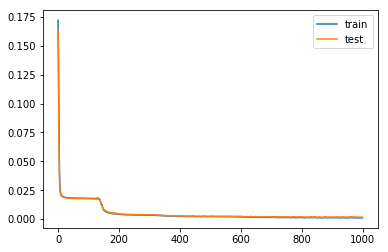

In [9]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.load_'+str(resol)+'.hdf5',
								   verbose=1, save_best_only=True)
# fit network
history = modelLoad.fit(x_train, y_train, epochs=1000, batch_size=30,
						validation_data=(x_val, y_val), verbose=2,
						callbacks=[checkpointer], shuffle=False)

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### Testing Model

In [ ]:
# reload parameters
modelLoad.load_weights('saved_models/weights.best.load_'+str(resol)+'.hdf5')

In [1]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

y_pred = modelLoad.predict(x_test)
print(y_pred.shape)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Mean Square Error: %f" % mse)
print("Mean Absolute Error: %f" % mae)

NameError: name 'modelLoad' is not defined

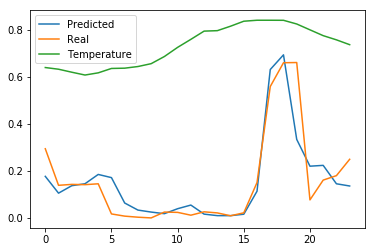

In [28]:

day = 178
plt.plot(y_pred[day,:], label='Predicted')
plt.plot(y_test[day,:], label='Real')
plt.plot(x_test[day,:,1], label='Temperature')
plt.legend()
plt.show()